In [1]:
# import sys
# sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
# sys.path

j_integral(kj/m^2): 59.69634668936897 
 elastic_k: 65.4234518932451


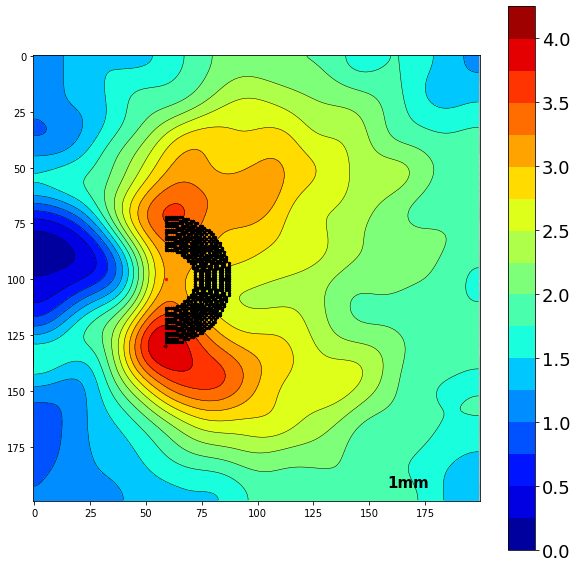

In [12]:
import mecha.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mecha.fracture
import matplotlib.patches as patches
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000

# Img parameter
contour_level = 15
ratio = 2/60
left, right, up_down = 50,150,100

# pick point
radius_gap = 1.5
gap_count = 12
start_gap = 0.45

path = r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC'
save_path =r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC/Output'
image = dic.load_file(path)
strain_data = np.array(pd.read_csv(path+'/effective_strain_ml_1.3더한거.csv', encoding='CP949', delimiter=' ',header=None))
strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))

crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x


i = 0 ##ref
j = 4##cur

cur = list(image.keys())[j]

src_reference = image['ff0870'][:,:,1][crack_tip[i][0]-up_down:crack_tip[i][0]+up_down,crack_tip[i][1]-left:crack_tip[i][1]+right]
src_current = image[cur][:,:,1][crack_tip[j][0]-up_down:crack_tip[j][0]+up_down,crack_tip[j][1]-left:crack_tip[j][1]+right]

dst = cv2.subtract(src_current,src_reference)
dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
gas = cv2.GaussianBlur(dst,(0,0),10)


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(src_current, cmap='gray')
# plt.axis('off')
csf = ax.contourf(gas, contour_level, cmap = 'jet')
CS = ax.contour(gas, contour_level, colors='black', linewidths = 0.5)

cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)
plt.text( 158,193, '1mm', fontsize=15, fontweight='bold')

# max_crack_tip = [left,up_down]
max_crack_tip = [np.argmax(gas)%(left+right), up_down]
# max_crack_tip = [np.argmax(gas)%(left+right), np.argmax(gas)//(left+right)]#x,y
# plt.scatter(max_crack_tip[0],max_crack_tip[1], color= 'black', s=10)

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,90,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,90,0)))
        radius_g += radius_gap

df = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df.x = df.x + max_crack_tip[0]
df.y = df.y + max_crack_tip[1]
df.r = df.r*0.001

plt.scatter(max_crack_tip[0], up_down, s = 5,  c = 'red')
plt.scatter(df.x, df.y, s = 5,  c='black')


hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df[['y','x','angle']]):
    current_ml = gas[np.round(y).astype(int),np.round(x).astype(int)]
    ml = np.append(ml, current_ml)
    effective_strain = np.append(effective_strain, strain_data[find_nearest(strain_data[:,1], current_ml),0])
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])


df['ml'] = ml
df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list

plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus
elastic_k1 = np.sqrt((j_integral * youngs_modulus))

print('j_integral(kj/m^2):', 1000*j_integral,'\n elastic_k:',elastic_k1)

In [ ]:
ax.add_patch(
     patches.Rectangle(
        (155, 184),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )

# plt.scatter(df['x'],df['y'],color='black',s=0.8)
# plt.title('Elastic k1: ' +  str(np.round(elastic_k1,3)) + '  | j : ' + str(np.round(j_integral,3)))
# plt.savefig(save_path+'./%d.png'%j,dpi=300, bbox_inches='tight')
plt.axis('off')
plt.savefig(r'E:\사진/컨투어%d.png'%j,dpi=300,bbox_inches='tight')
print(elastic_k1,j_integral)

gas_strain = gas.copy()
for i_ in range(np.shape(gas_strain)[0]):
    for j_ in range(np.shape(gas_strain)[1]):
        value = strain_data[find_nearest(strain_data[:,1],gas_strain[i_][j_]), 0]
        gas_strain[i_][j_] = value

fig, ax = plt.subplots(figsize=(10, 10))



ax.imshow(src_current, cmap='gray')
# plt.axis('off')
csf = ax.contourf(gas_strain, contour_level, cmap = 'jet')
CS = ax.contour(gas_strain, contour_level, colors='black', linewidths = 0.5)


cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)

plt.scatter(max_crack_tip[0],max_crack_tip[1], color='blue', s=15,zorder=10)
plt.scatter(50,100, color='purple', s=15,zorder=11)
ax.text( 158,193, '1mm', fontsize=9, fontweight='bold')
ax.axis('off')
plt.savefig(r'E:\사진/effective%d.png'%j,dpi=300,bbox_inches='tight')

In [48]:
df[df['angle']==0]

,x,y,angle,r,ml,effective_strain,hardening_strain_bar,plastic_k
0,59.0,91.0,0,0.0003,3.075405,0.0280,0.198768,0.781660
1,59.0,91.0,0,0.0003,3.075405,0.0280,0.208796,0.779400
2,59.0,91.0,0,0.0003,3.075405,0.0280,0.220661,0.776870
3,59.0,91.0,0,0.0003,3.075405,0.0280,0.233316,0.774326
4,60.0,91.0,0,0.0003,3.104506,0.0285,0.245399,0.772834
...,...,...,...,...,...,...,...,...
1986,61.0,124.0,0,0.0008,3.867469,0.0355,0.245399,0.826727
1987,60.0,124.0,0,0.0008,3.881995,0.0355,0.233316,0.829186
1988,60.0,124.0,0,0.0008,3.881995,0.0355,0.220661,0.831910
1989,59.0,124.0,0,0.0008,3.889019,0.0355,0.208796,0.834619


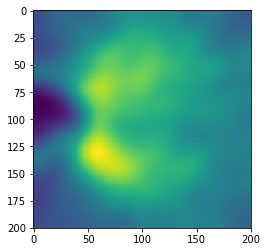

In [3]:
plt.text( 158,193, '1mm', fontsize=9, fontweight='bold')
cur = cv2.equalizeHist(src_current)
plt.imshow(cur, cmap='gray')
plt.axis('off')
plt.show()
# plt.savefig(r'E:\사진/d%d.png'%j,dpi=300,bbox_inches='tight')
plt.close()

plt.text( 158,193, '1mm', fontsize=9, fontweight='bold')
plt.imshow(src_current, cmap='gray')
plt.axis('off')
plt.show()
# plt.savefig(r'E:\사진/dd%d.png'%j,dpi=300,bbox_inches='tight')
plt.close()


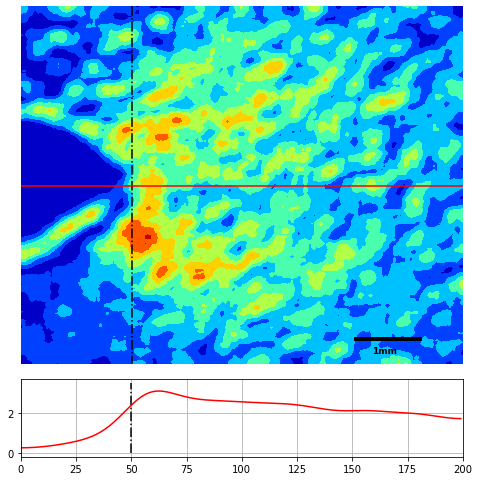

Save Done


In [7]:
import pickle
import cv2

from matplotlib.gridspec import GridSpec
gas = cv2.GaussianBlur(dst,(9,9),10)
ee_resize = gas#%%
gas = cv2.GaussianBlur(dst,(0,0),10)
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=6, ncols=5)
# First axes
ax0 = fig.add_subplot(gs[0:4, 0:4])
# ax0.imshow(ee_resize,cmap='gray')
plt.contourf(ee_resize, cmap= 'jet')
ax0.vlines(50,0,np.shape(ee_resize)[0]-1, color='black', linestyles='-.')
ax0.hlines(100,0,np.shape(ee_resize)[1]-1, color='red')
plt.gca().invert_yaxis()
ax0.text( 158,193, '1mm', fontsize=9, fontweight='bold')
ax0.axis('off')
ax0.add_patch(
     patches.Rectangle(
        (150, 184),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )

# v axes
# ax1 = fig.add_subplot(gs[0:4, 4])
# ax1.plot(value[:,x_point],np.arange(len(value[:,x_point])),color='red')
# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()
# plt.gca().invert_yaxis()
# u axes
profile_strain=gas[100,:]
#
# for i in range(np.shape(ee_resize[100,:])[0]):
#     profile_strain = np.append(profile_strain, strain_data[find_nearest(strain_data[:,1], ee_resize[100,i]),0])
#

ax2 = fig.add_subplot(gs[4, 0:4])


ax2.plot(profile_strain, color='red')
# ax2.plot(ee_resize[100,:])
# ax2.plot(savgol_filter(value[:,y_point],31,2), color='green')

ax2.vlines(50,0,3.5, color='black', linestyles='-.')
# ax2.set_ylim(0,3.5)
ax2.set_xlim(0,200)
plt.grid()
plt.savefig(save_path+'/%dslop.3더한거.png'%j, dpi=300)
# plt.close()

plt.show()
plt.close()
with open('./ml.pkl','wb') as f:
    pickle.dump(ee_resize, f)

print('Save Done')

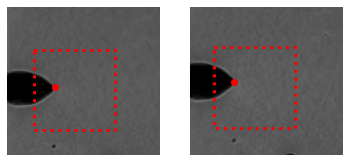

In [6]:
left_cut = 90
rigt_cut = -300
up_down_cut = 200
fig,ax = plt.subplots(1,2)

ax[0].imshow(image['ff0870'][up_down_cut:-up_down_cut,left_cut:rigt_cut])
ax[0].scatter(crack_tip[0][1]-left_cut,crack_tip[0][0]-up_down_cut,c='red')
ax[0].add_patch(
     patches.Rectangle(
        (crack_tip[0][1]-left-left_cut, crack_tip[0][1]+up_down-up_down_cut),
        right+left,
        up_down*2,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )
ax[0].axis('off')

ax[1].imshow(image['ff3569'][up_down_cut:-up_down_cut,left_cut:rigt_cut])
ax[1].scatter(crack_tip[-1][1]-left_cut,crack_tip[-1][0]-up_down_cut,c='red')
ax[1].add_patch(
     patches.Rectangle(
        (crack_tip[-1][1]-left-left_cut, crack_tip[-1][1]+up_down-up_down_cut),
        right+left,
        up_down*2,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )
ax[1].axis('off')

plt.savefig(r'E:\사진/겹d치기%d.png'%j,dpi=300,bbox_inches='tight')